In [ ]:
# !pip install rank_bm25 --quiet #install BM25
# !pip install --no-binary :all: nmslib #install nmslib
# !pip install ftfy
import pandas as pd
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from rank_bm25 import BM25Okapi
import ftfy
import nmslib
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

In [ ]:
organizations1 = pd.read_csv('/content/drive/MyDrive/data/organizations.csv')
organizations2 = pd.read_csv('/content/drive/MyDrive/data/organization_descriptions.csv')

In [ ]:
organizations1.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,domain,homepage_url,country_code,state_code,region,city,address,postal_code,status,short_description,category_list,category_groups_list,num_funding_rounds,total_funding_usd,total_funding,total_funding_currency_code,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits,revenue_range
0,b531d0a8-52dd-4189-91d1-3d7432d78d71,Meridian Entertainment Group,organization,meridian-entertainment-group,https://www.crunchbase.com/organization/meridian-entertainment-group,585500.0,2017-11-10 19:44:02,2019-03-30 01:33:40,NaN,company,meridianconcerts.com,http://meridianconcerts.com,NaN,NaN,NaN,NaN,NaN,NaN,operating,"Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan.","Consulting,Events","Events,Media and Entertainment",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-10,info@meridianconcerts.com,231-935-3900,https://www.facebook.com/meridianentertainmentgroup,NaN,https://www.twitter.com/meridianconcert,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1509753042/iirm0g9yl4qxexn8uooc.jpg",NaN,NaN,NaN,company,NaN,NaN
1,094dbc9c-ca77-ec1c-4a92-be1092ef1052,RushRate,organization,rushrate,https://www.crunchbase.com/organization/rushrate,602764.0,2016-11-14 11:59:52,2018-02-12 23:27:40,NaN,company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,operating,Ranking potential members of a fraternity.,"Communities,Internet","Community and Lifestyle,Internet Services",1.0,NaN,NaN,NaN,NaN,2016-10-01,NaN,unknown,NaN,NaN,NaN,NaN,NaN,"https://crunchbase-production-res.cloudinary.com/image/upload/h_120,w_120,f_jpg/v1507847753/placeholder_zgpxrr.png",NaN,NaN,NaN,company,NaN,NaN
2,d103ef85-1ac5-e952-2784-1d8f321aa0b3,Bishop Canevin High School,organization,bishop-canevin-high-school,https://www.crunchbase.com/organization/bishop-canevin-high-school,483700.0,2016-05-18 18:53:33,2018-10-26 21:47:45,NaN,school,bishopcanevin.org,http://bishopcanevin.org/,USA,PA,Pennsylvania,Pittsburgh,2700 Morange Road,15205,operating,"Bishop Canevin High School is a Catholic high school in Pittsburgh, Pennsylvania.","E-Learning,Education,Higher Education","Education,Software",NaN,NaN,NaN,NaN,1958-08-17,NaN,NaN,101-250,info@bishopcanevin.org,412.456.3000,https://www.facebook.com/bishopcanevin,https://www.linkedin.com/company/bishop-canevin-high-school,https://twitter.com/bishopcanevin,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1463597520/imq2izxki4y29jkynpit.jpg",NaN,NaN,NaN,school,NaN,NaN
3,0fbfb7ac-4015-1561-6d42-ec9c4a87a324,Paladina Health,organization,paladina-health,https://www.crunchbase.com/organization/paladina-health,7675.0,2016-09-02 08:49:36,2018-10-26 23:08:51,NaN,company,paladinahealth.com,http://www.paladinahealth.com,USA,CO,Colorado,Denver,1551 Wewatta Street,80202,acquired,Paladina Health is an innovative employer-sponsored healthcare provider.,"Health Care,Hospital,Medical,Personal Health",Health Care,1.0,165000000.0,165000000.0,USD,2010-01-01,2018-08-23,NaN,11-50,memberservices@paladinahealth.com,303-405-2100,https://www.facebook.com/206019739569801,https://www.linkedin.com/company/paladina-health,https://www.twitter.com/paladinahealth,"https://crunchbase-production-res.cloudinary.com/image/upload/c_lpad,h_120,w_120,f_jpg/v1472806170/sm4hopceixrj5dtprlwq.png",NaN,NaN,NaN,company,NaN,NaN
4,1ec47fa1-0727-4a87-b872-7128ec94e7cd,Spire Group,organization,spire-group-pc,https://www.crunchbase.com/organization/spire-group-pc,520650.0,2018-12-17 09:57:58,2018-12-17 10:02:14,NaN,company,spirecpa.com,http://www.spirecpa.com,USA,NJ,New Jersey,Clark,100 Walnut Avenue Suite 103,07066,acquired,Spire Group is a full-service accounting and consulting firm.,"Accounting,Consulting","Financial Services,Professional Services",NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,NaN,https://w

In [ ]:
organizations2.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,description
0,65c154f7-8992-4c2e-99c4-e755089987c8,Old Liquors Invest,organization,old-liquors-invest,https://www.crunchbase.com/organization/old-liquors-invest,310817.0,2019-01-25 11:49:42,2019-02-14 01:18:05,"The Corporate bonds Series OLI-III-B is offered by Old Liquors Invest III B.V. The issuer has as its principal activity the speculative investing in old beverages such as Whiskey, Cognac, Armagnac, Port, Liqueurs, Madeira wines, and other rare and old or special alcoholic beverages."
1,bd565ade-4b23-4bb0-b965-97fb95b95775,Padoq,organization,padoq,https://www.crunchbase.com/organization/padoq,41514.0,2017-10-09 11:59:00,2018-05-02 09:27:38,"Padoq is a community network platform revolutionising the way communities interact, engage, and make payments online. Launching - June 2018."
2,5a6370b5-1176-473f-a27d-49e75cd49edf,Mainland,organization,mainland,https://www.crunchbase.com/organization/mainland,340555.0,2018-06-19 04:07:17,2018-10-26 22:44:46,"Enrich lives. That's what we're all about. It's the reason we come to work every day. It's the life blood that flows through all aspects of the company. Loneliness sucks. Everyone knows this because everyone has experienced it at one point or another. But if someone doesn't want to be lonely and truly want more friends, shouldn't there be an easy way to make that happen? Well we think so. How do we enrich lives? By simply bringing people together. A new best friend could be right around the corner. So join us. Because here at Mainland we understand no one's and island."
3,8b8fe41c-07dc-4039-b311-022381af39f5,Kaffeen,organization,kaffeen,https://www.crunchbase.com/organization/kaffeen,63096.0,2019-04-01 17:14:25,2019-04-01 23:14:03,"Kaffeen mobile application is the first mobile application in Saudi Arabia that is specialized in online coffee ordering. It allows users to order/pre-order their coffee online and pick it up, with no extra charge, from the pick-up counter. If want to save time, or simply do not want to wait in line, Kaffeen is your go-to mobile application."
4,786293a8-f675-40d8-8516-430c8f4c236a,Webstage,organization,webstage,https://www.crunchbase.com/organization/webstage,442866.0,2018-02-13 05:20:36,2019-03-25 20:27:17,"WebStage is a Target Fuel technology that was born when experts in the fields of online marketing, website personalization and web analytics teamed up to make website marketing less “technical”. Websites have always presented a challenge for marketers who don’t have a computer science degree. Most of the time, someone else codes the website, someone else oversees the website, and someone else owns the website! WebStage provides easy ways to personalize content without delays or technical expertise. It allows any marketer to quickly and easily add or alter web content to keep on-site visitors informed and engaged. In minutes, marketers can launch personalized content on any number of pages for different target audiences - a task that typically takes weeks and cost thousands."


In [ ]:
org1_cols = ['uuid','name','type','permalink','rank','short_description','domain','num_funding_rounds','total_funding','total_funding_currency_code','founded_on','employee_count']
org2_cols =['uuid','name','type','permalink','rank','description']
org1 = organizations1[org1_cols]
org2 = organizations2[org2_cols]

In [ ]:
org1 = org1.rename(columns = {'short_description':'description'})

In [ ]:
final_orgs = pd.concat([org1,org2])
final_orgs = final_orgs.reset_index()

In [ ]:
final_orgs.nunique()

index                          50 
uuid                           100
name                           100
type                           1  
permalink                      100
rank                           100
description                    100
domain                         47 
num_funding_rounds             3  
total_funding                  7  
total_funding_currency_code    3  
founded_on                     32 
employee_count                 8  
dtype: int64

In [ ]:
final_orgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        100 non-null    int64  
 1   uuid                         100 non-null    object 
 2   name                         100 non-null    object 
 3   type                         100 non-null    object 
 4   permalink                    100 non-null    object 
 5   rank                         100 non-null    float64
 6   description                  100 non-null    object 
 7   domain                       47 non-null     object 
 8   num_funding_rounds           13 non-null     float64
 9   total_funding                7 non-null      float64
 10  total_funding_currency_code  7 non-null      object 
 11  founded_on                   36 non-null     object 
 12  employee_count               50 non-null     object 
dtypes: float64(3), int64(

In [ ]:
df = final_orgs.copy()

In [ ]:
df = df.fillna('Not Registered')

In [ ]:
df['text'] = df['name'] + ' ' + df['permalink']+ ' ' + df['description'] + ' ' + df['uuid']
df.shape

(100, 14)

In [ ]:
df.head(1)

,index,uuid,name,type,permalink,rank,description,domain,num_funding_rounds,total_funding,total_funding_currency_code,founded_on,employee_count,text
0,0,b531d0a8-52dd-4189-91d1-3d7432d78d71,Meridian Entertainment Group,organization,meridian-entertainment-group,585500.0,"Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan.",meridianconcerts.com,Not Registered,Not Registered,Not Registered,Not Registered,1-10,"Meridian Entertainment Group meridian-entertainment-group Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan. b531d0a8-52dd-4189-91d1-3d7432d78d71"


### Preprocess and tokenise

In [ ]:
nlp = spacy.load("en_core_web_sm")
text_list = df.text.str.lower().values
tok_text=[] # for our tokenised corpus
#Tokenising using SpaCy:
for doc in tqdm(nlp.pipe(text_list, disable=["tagger", "parser","ner"])):
   tok = [t.text for t in doc if t.is_alpha]
   tok_text.append(tok)

100it [00:00, 783.91it/s]


#### Simple Search using BM25 Algorithm

In [ ]:
bm25 = BM25Okapi(tok_text)

In [188]:
def search1(query):
  Results = {}
  tokenized_query = query.lower().split(" ")
  import time
  t0 = time.time()
  results = bm25.get_top_n(tokenized_query, df['text'].values, n=3)
  t1 = time.time()
  print(f'Searched 100 records in {round(t1-t0,3) } seconds \n')
  for i in results:

    Companies = {}
    uuid = df[df['text']==i]['uuid'].values[0]
    name = df[df['text']==i]['name'].values[0]
    description = df[df['text']==i]['description'].values[0]
    domain = df[df['text']==i]['domain'].values[0]
    totalFunding = df[df['text']==i]['total_funding'].values[0]
    num_funding_rounds = df[df['text']==i]['num_funding_rounds'].values[0]
    Total_funding_currency_code = df[df['text']==i]['total_funding_currency_code'].values[0]
    Founded_on = df[df['text']==i]['founded_on'].values[0]
    employee_count = df[df['text']==i]['employee_count'].values[0]

    Companies['UUID'] = uuid
    Companies['Name']= name
    Companies['Description']= description
    Companies['Domain']= domain
    Companies['Total_Funding']= totalFunding
    Companies['Num_Funding_Rounds']= num_funding_rounds
    Companies['Total_Funding_Currency_Code']= Total_funding_currency_code
    Companies['Founded_On']= Founded_on
    Companies['Employee_Count']= employee_count

    Results[name] = Companies

  print("======Search Results=========")
  for m,n in enumerate(Results):
    print(f"\nResult {m+1}:")
    print(n, Results[n])

In [189]:
search1('Eureka')

Searched 100 records in 0.001 seconds 

======Search Results=========

Result 1:
Eureka King Inc. {'UUID': 'a6e51ef4-29f0-f852-d1c4-e72207533c57', 'Name': 'Eureka King Inc.', 'Description': "Eureka king enables publishers to maximize the life-time value of their users across web and mobile, by delivering actionable, responsive and sequential user notifications throughout the user journey. In 2014, companies spent $46 BN to acquire traffic to their websites. However, less than 10% of traffic yielded long-term value for the businesses. We engineered Eureka King to guide your visitors through a deliberate user journey, mapped for maximum value.  Eureka King's behavior-tracking engine analyzes users actions and intent in Real-time to deliver optimal user-prompts. Our dynamic user-prompts adapt to the users' journey and enables publishers to intelligently promote a product, encourage signups, transact payments, and a variety of transactions customized for the publisher’s needs. Using our Sa

In [190]:
search1('Consulting firm')

Searched 100 records in 0.001 seconds 

======Search Results=========

Result 1:
Spire Group {'UUID': '1ec47fa1-0727-4a87-b872-7128ec94e7cd', 'Name': 'Spire Group', 'Description': 'Spire Group is a full-service accounting and consulting firm.', 'Domain': 'spirecpa.com', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Currency_Code': 'Not Registered', 'Founded_On': 'Not Registered', 'Employee_Count': 'unknown'}

Result 2:
Binary Mango {'UUID': '758f0b00-65fc-8dae-f38a-fa4bbb01a4c9', 'Name': 'Binary Mango', 'Description': 'Hi-tech Development Firm', 'Domain': 'thebinarymango.com', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Currency_Code': 'Not Registered', 'Founded_On': '2016-09-06', 'Employee_Count': 'unknown'}

Result 3:
ALBERT {'UUID': 'daa9dd72-86f3-bafd-c9ec-88fb18eeed2a', 'Name': 'ALBERT', 'Description': 'ALBERT offers businesses with analytics and consulting services to assist them in their bu

In [187]:
search1('Whiskey')

Searched 100 records in 0.0 seconds 

======Search Results=========

Result 1:
Old Liquors Invest {'UUID': '65c154f7-8992-4c2e-99c4-e755089987c8', 'Name': 'Old Liquors Invest', 'Description': 'The Corporate bonds Series OLI-III-B is offered by Old Liquors Invest III B.V. The issuer has as its principal activity the speculative investing in old beverages such as Whiskey, Cognac, Armagnac, Port, Liqueurs, Madeira wines, and other rare and old or special alcoholic beverages.', 'Domain': 'Not Registered', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Currency_Code': 'Not Registered', 'Founded_On': 'Not Registered', 'Employee_Count': 'Not Registered'}

Result 2:
Fully Functional {'UUID': '1f19206c-6ec6-42d4-9204-2e55fb8ad3bd', 'Name': 'Fully Functional', 'Description': 'Allied Healthcare and Health resource website', 'Domain': 'fullyfunctional.com.au', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Curren

#### Smart Search using fasttext, BM25 and NMSLIB

In [191]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

In [192]:
ft_model = FastText.load('_fasttext.model')

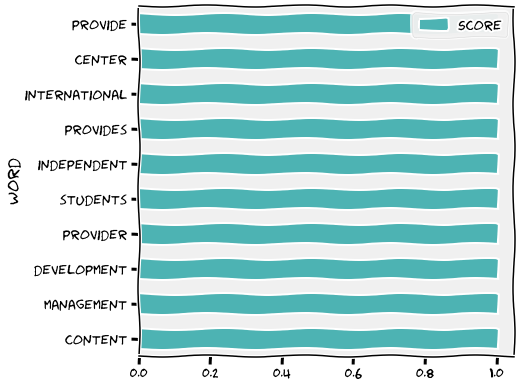

In [193]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("entertainment", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

In [194]:
weighted_doc_vects = []
words = []

for i,doc in enumerate(tok_text):
  doc_vector = []
  for word in doc:
    vector = ft_model.wv[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)
  
  pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) ) #save the results to disc

In [195]:
with open( "weighted_doc_vects.p", "rb" ) as f:
  weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [204]:
# querying the index:

def search2(input):
  Results = {}
  input = input.lower().split()
  query = [ft_model[vec] for vec in input]
  query = np.mean(query,axis=0)
  t0 = time.time()
  ids, distances = index.knnQuery(query, k=5)
  t1 = time.time()
  print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
  for ind,j in zip(ids,distances):
    i = df.text.values[ind]

    Companies = {}
    uuid = df[df['text']==i]['uuid'].values[0]
    name = df[df['text']==i]['name'].values[0]
    description = df[df['text']==i]['description'].values[0]
    domain = df[df['text']==i]['domain'].values[0]
    totalFunding = df[df['text']==i]['total_funding'].values[0]
    num_funding_rounds = df[df['text']==i]['num_funding_rounds'].values[0]
    Total_funding_currency_code = df[df['text']==i]['total_funding_currency_code'].values[0]
    Founded_on = df[df['text']==i]['founded_on'].values[0]
    employee_count = df[df['text']==i]['employee_count'].values[0]

    Companies['UUID'] = uuid
    Companies['Name']= name
    Companies['Description']= description
    Companies['Domain']= domain
    Companies['Total_Funding']= totalFunding
    Companies['Num_Funding_Rounds']= num_funding_rounds
    Companies['Total_Funding_Currency_Code']= Total_funding_currency_code
    Companies['Founded_On']= Founded_on
    Companies['Employee_Count']= employee_count
    # print(f"\nSearch result: {i} \n\nOrganization: {df[df['text']==val]['name']} \n")
    # print("=================================")

    Results[name] = Companies
  print("======Search Results=========")
  for m,n in enumerate(Results):
    print(f"\nResult {m+1}:")
    print(n, Results[n])


In [205]:
search2('Melhor')

Searched 100 records in 0.0005 seconds 

======Search Results=========

Result 1:
O Melhor Fornecedor {'UUID': '4e9b2382-1a16-af70-4d57-68be30036423', 'Name': 'O Melhor Fornecedor', 'Description': 'O Melhor Fornecedor is an online B2B marketplace that enables its users to find qualified suppliers to fulfill their needs. It enables them to receive quotes for free, compare prices, find suppliers within a limited location, and more.', 'Domain': 'Not Registered', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Currency_Code': 'Not Registered', 'Founded_On': 'Not Registered', 'Employee_Count': 'Not Registered'}

Result 2:
Webstage {'UUID': '786293a8-f675-40d8-8516-430c8f4c236a', 'Name': 'Webstage', 'Description': 'WebStage is a Target Fuel technology that was born when experts in the fields of online marketing, website personalization and web analytics teamed up to make website marketing less “technical”. Websites have always presented a challenge f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [206]:
search2('Meridian groups')

Searched 100 records in 0.0001 seconds 

======Search Results=========

Result 1:
Meridian Entertainment Group {'UUID': 'b531d0a8-52dd-4189-91d1-3d7432d78d71', 'Name': 'Meridian Entertainment Group', 'Description': 'Meridian Entertainment Group provides with event and entertainment consultation, programming and management services in Michigan.', 'Domain': 'meridianconcerts.com', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Currency_Code': 'Not Registered', 'Founded_On': 'Not Registered', 'Employee_Count': '1-10'}

Result 2:
SGM Law Group, Law Offices of Shilpa Malik {'UUID': '040b8bfa-3262-8af7-47dd-50b1ef77b97e', 'Name': 'SGM Law Group, Law Offices of Shilpa Malik', 'Description': 'SGM Law Group is a well-known immigration firm in Fort Lauderdale, FL delivering the most up-to-date immigration services', 'Domain': 'immi-usa.com', 'Total_Funding': 'Not Registered', 'Num_Funding_Rounds': 'Not Registered', 'Total_Funding_Currency_Code': 'Not Re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
